> Oscar PERIANAYAGASSAMY, Projet M2 IASD App. - Apprentissage par Renforcement

In [17]:
%pip install numpy matplotlib gymnasium swig "gymnasium[box2d]" torch stable_baselines3 "stable_baselines3[extra]" "gymnasium[other]" setuptools ipykernel pathlib --upgrade pip

  Using cached pathlib-1.0.1-py3-none-any.whl.metadata (5.1 kB)
  Using cached pip-26.0.1-py3-none-any.whl.metadata (4.7 kB)
Using cached pathlib-1.0.1-py3-none-any.whl (14 kB)
Using cached pip-26.0.1-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 25.2
    Uninstalling pip-25.2:
      Successfully uninstalled pip-25.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [pip]1/2 [pip]
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.colors
import torch
import random
from gymnasium.wrappers import RecordVideo
import gymnasium as gym
import stable_baselines3 as sb3
from stable_baselines3 import DQN, PPO, A2C
from typing import Iterable, Dict, Mapping
from abc import ABCMeta # Abstract class en python
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker



COLORS = matplotlib.colors.CSS4_COLORS

# 1 - Cadre du problème

Le but est de faire alunir un aéronef entre deux drapeaux colorés. Le problème possède les dimensions suivantes : 
- <u>Espace des actions</u> : `Discrete(4)`, c'est-à-dire que 4 actions sont à notre disposition, $|A|=4$ : 
    * 0 : ne rien faire
    * 1 : actionner le moteur gauche
    * 2 : actionner le moteur central
    * 3 : actionner le moteur droit
- <u>Espace des observations</u> : `Box([ -2.5 -2.5 -10. -10. -6.2831855 -10. -0. -0. ], [ 2.5 2.5 10. 10. 6.2831855 10. 1. 1. ], (8,), float32)`, c'est-à-dire qu'une observation est un tenseur de dimensions 8 défini de la manière suivante : $s \in S, s = [x, y, v_x, v_y, \theta, v_\theta, c_{left}, c_{right}]^T$. 
    * $x, y \in [-2.5, 2.5]^2$ sont les coordonnées du module 
    * $v_x, v_y \in [-10, 10]^2$  ses vélocités linéaires en $x$ et $y$
    * $\theta \in [-6.2831855, 6.2831855]$ son angle
    * $v_\theta \in [-10, 10]$ sa vélocité angulaire 
    * $c_{left}, c_{right} \in \{0,1\}^2$ des booléens qui indiquent si l'une des jambes du module est en contact avec le sol.
- <u>Espace des récompenses</u> : la récompense est modifiée dans les situations suivantes : 
    * +/- selon la distance à la zone d'alunissage
    * +/- selon la vitesse du module
    * \- si le module n'est pas à l'horizontal
    * +10 pour chaque pied en contact avec le sol
    * \- 0.03 pour chaque actionnement d'un moteur de côté
    * \- 0.3 pour chaque actionnement du moteur central
    * +/- 100 selon si l'on s'est posé correctement/crashé

    Un épisode est considéré réussi si $\sum_{k=0}^{T} r_k \ge 200$.


Il est clair que ce problème ne pourra pas être résolu avec des méthodes tabulaires. En effet, les actions sont dans un espace discret mais les états appartiennent au domaine du continu. Nous devons donc adopté une méthode utilisant des réseaux de neurones pour approximer la fonction de valeurs.

Le problème de départ est <b>stationnaire</b> et <b>épisodique</b>.

# 2 - Évaluation de $DQN$, $\mathcal{PPO}$ et $\mathcal{A2C}$ 

Nous rappelons qu'en raison de la taille de l'espace des états, il est impossible de stocker les valeurs de $Q(s,a)$ pour tout état $s$ et action $a$. Nénmoins, le nombre d'actions est fini ce qui nous encourage à teste `DQN`. En effet, il s'agit d'un algorithme qui approxime la valeur de $Q(s,a)$ avec un réseau de neuronnes. En théorie nous avons aucunes garanties de converger vers la solution optimale. Néanmoins, le replay buffer qui permet de simuler des séquences non-vues jusqu'à présent nous permettra de gagner en stabilité.

Nous testerons également `PPO` comme méthode de "policy gradient" et A2C comme méthode d'acteur-critique afin d'évaluer leur pertinence dans ce contexte. Là où `DQN` est l'algorithme initiateur du deep reinforcemenet learning, `PPO` vient apporter une solution différente en approchant la politique. `A2C`, lui, vient mélanger les deux approches : l'acteur choisit la meilleure action selon l'état à partir d'une politique apprise $\pi(\cdot)$ et le critique évalue la valeur de $Q(s,a)$.

In [2]:
# Définition du device pour le stockage des tenseurs torch
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

# Définition de la graîne de reproductibilité
seed = 42
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

print(f"Les calculs seront effectués sur {device}.")

Les calculs seront effectués sur mps.


Création d'une classe pour automatiser l'entrainement des modèles sur plusieurs taux d'apprentissage et environnement différents.

In [3]:
# Définition du matériel où l'on travaille
device = torch.accelerator.current_accelerator().type
print(f"Travail sur {device}")

# Dossier pour stocker les logs d'apprentissage
logdir = Path() / "logs" / "comparaison_lunar_lander"
logdir.mkdir(parents=True, exist_ok=True)

# Dossier pour stocker les modèles entrainés
modeldir = Path() / "models" / "lunar_lander"
modeldir.mkdir(parents=True, exist_ok=True)

# ----------------- DÉFINITION DES PARAMÈTRES D'APPRENTISSAGE ----------------- #
learning_rates: torch.Tensor = torch.logspace(-7, -2, 5, base=10) # Répartition logarithmique des learning rates
POLICY: str = "MlpPolicy" # MultiLayerPerceptron policy ie le réseau de neuronnes utilisé par l'algo est un réseau entièrement connecté
algorithms: Dict[str, Mapping] = {
    "DQN": {"verbose": 0, "tensorboard_log": logdir, "device": device},
    "PPO": {"verbose": 0, "tensorboard_log": logdir, "device": device},
    "A2C": {"verbose": 0, "tensorboard_log": logdir, "device": device},
}


class LearningScheduler:
    """Classe qui représente un outil pour apprendre en masse des modèles en fonction de scenari et de learning rates différents"""
    
    """ Exemple d'environnements qui ont été entrainés
    ENVS = {
        "classic-vanilla": {
            "env": gym.make("LunarLander-v3", continuous=False, gravity=-10.0, enable_wind=False, wind_power=15., turbulence_power=1.5, render_mode=None),
            "models": ["DQN", "A2C", "PPO"],
            "training_timesteps": 2e5
        },
        "classic-continuous": {
            "env": gym.make("LunarLander-v3", continuous=True, gravity=-10.0, enable_wind=False, wind_power=15., turbulence_power=1.5, render_mode=None),
            "models": ["A2C", "PPO"],
            "training_timesteps": 2e5
        },
        "windy-vanilla": {
            "env": gym.make("LunarLander-v3", continuous=False, gravity=-10.0, enable_wind=True, wind_power=15., turbulence_power=1.5, render_mode=None),
            "models": ["DQN", "A2C", "PPO"],
            "training_timesteps": 2e5
        },
        "windy-continuous": {
            "env": gym.make("LunarLander-v3", continuous=True, gravity=-10.0, enable_wind=True, wind_power=15., turbulence_power=1.5, render_mode=None),
            "models": ["A2C", "PPO"],
            "training_timesteps": 2e5
        },
        "zero-gravity-windy-vanilla": {
                "env": gym.make("LunarLander-v3", continuous=False, gravity=-0.01, enable_wind=True, wind_power=15., turbulence_power=1.5, render_mode=None),
                "models": ["DQN"],#, "A2C", "PPO"],
                "training_timesteps": 2e5
            },
        "zero-gravity-windy-continuous": {
                "env": gym.make("LunarLander-v3", continuous=True, gravity=-0.01, enable_wind=True, wind_power=15., turbulence_power=1.5, render_mode=None),
                "models": ["A2C", "PPO"],
                "training_timesteps": 2e5
            },
        }
    """
    ENVS = {
        ...: { # INSERT HERE : insérer ici le label de la méthode que vous souhaitez entrainer
                "env": ..., # INSERT HERE : gym env  (e.g. gym.make("LunarLander-v3", continuous=False, gravity=-0.01, enable_wind=True, wind_power=15., turbulence_power=1.5, render_mode=None))
                "models": ..., # INSERT HERE : Liste des algo à entrainer (e.g. ["DQN"])
                "training_timesteps": ..., # INSERT HERE : nombre de timesteps pour l'entrainement #5000
            },
    }

    def __init__(self, 
                 env=gym.make("LunarLander-v3", continuous=False, gravity=-10.0, enable_wind=False, wind_power=15., turbulence_power=1.5, render_mode=None), 
                 algorithms: Mapping[str, Mapping]=None, 
                 learning_rates: Iterable[float]=None, 
                 training_timesteps: float=-1, 
                 environment_mode: str="default"
            ):
        assert all([algorithms, training_timesteps, environment_mode]) and type(learning_rates) != type(None) , "Tous les arguments ne sont pas renseignés correctement"

        # Définition des paramètres d'apprentissage pour les algorithmes
        self.algorithms_kwargs = algorithms
        self.training_timesteps = training_timesteps

        # Enregistrement des learning rates disponibles
        self.lr = learning_rates

        # Enregistrement du mode de l'environnement
        self.environment_mode = environment_mode

        # Définition d'un env par défaut
        self.env = env

        # Définition des modèles par défaut
        self.DQN = DQN(POLICY, env, **algorithms["DQN"]) if "DQN" in algorithms.keys() else None
        self.PPO = PPO(POLICY, env, **algorithms["PPO"]) if "PPO" in algorithms.keys() else None
        self.A2C = A2C(POLICY, env, **algorithms["A2C"]) if "A2C" in algorithms.keys() else None

    def reset_DQN(self, learning_rate: float=None, **kwargs):
        """Reset le modèle DQN enregistré avec un nouveau learning rate"""
        assert "DQN" in self.algorithms_kwargs.keys() or kwargs, "Aucun argument n'a été renseigné pour initialisé DQN"
        self.DQN = DQN(POLICY, self.env, **self.algorithms_kwargs["DQN"], learning_rate=learning_rate if learning_rate else {}) if "DQN" in self.algorithms_kwargs.keys() else DQN(**kwargs)

    def reset_PPO(self, learning_rate: float=None, **kwargs):
        """Reset le modèle PPO enregistré avec un nouveau learning rate"""
        assert "PPO" in self.algorithms_kwargs.keys() or kwargs, "Aucun argument n'a été renseigné pour initialisé PPO"
        self.PPO = PPO(POLICY, self.env, **self.algorithms_kwargs["PPO"], learning_rate=learning_rate if learning_rate else {}) if "PPO" in self.algorithms_kwargs.keys() else PPO(**kwargs)

    def reset_A2C(self, learning_rate: float=None, **kwargs):
        """Reset le modèle A2C enregistré avec un nouveau learning rate"""
        assert "A2C" in self.algorithms_kwargs.keys() or kwargs, "Aucun argument n'a été renseigné pour initialisé PPO"
        self.A2C = A2C(POLICY, self.env, **self.algorithms_kwargs["A2C"], learning_rate=learning_rate if learning_rate else {}) if "A2C" in self.algorithms_kwargs.keys() else A2C(**kwargs)

    def update_env(self, training_timesteps, environment_mode, env):
        """Mise-à-jour de l'environnement gym avec un nouveau mode d'exécution et un nouveau nombre de pas d'apprentissage"""
        self.environment_mode = environment_mode
        self.env = env
        self.training_timesteps = training_timesteps

    
    def train_loop_with_log(self):
        """Fonction d'entrainement des modèles"""
        
        # Pour chaque scénario... (e.g. windy-vanilla)
        for environment_mode in LearningScheduler.ENVS.keys():

            # Récupération des variables associées à ce scénario
            models = LearningScheduler.ENVS[environment_mode]["models"] # Liste des modèles à entrainer dans ce scénario (e.g. [A2C, PPO] pour windy-continuous)
            env = LearningScheduler.ENVS[environment_mode]["env"] # Récupération de l'environnement gym initialisé
            training_timesteps = LearningScheduler.ENVS[environment_mode]["training_timesteps"] # Récupération du nombre total de timesteps

            # Mise-à-jour de l'environnement courant enregistré dans la structure
            self.update_env(training_timesteps, environment_mode, env)

            # Pour chaque learning rate...
            for lr in self.lr:

                # Pour chaque algorithme à entrainer...
                for model_name in models:
                    
                    # Remise à zero de l'environnement
                    env.reset(seed=seed)
                    env.action_space.seed(seed)
                    env.observation_space.seed(seed)

                    # Nom utilisé pour l'enregistrement
                    name = f"{model_name}_{lr:.7f}_{int(self.training_timesteps//1e3)}K_{self.environment_mode}"

                    # Choix du modèle/de l'algorithme
                    model = ""
                    if model_name == "DQN" and self.DQN:
                        self.reset_DQN(learning_rate=float(lr))
                        model = self.DQN
                    elif model_name == "A2C" and self.A2C:
                        self.reset_A2C(learning_rate=float(lr))
                        model = self.A2C
                    elif model_name == "PPO" and self.PPO:
                        self.reset_PPO(learning_rate=float(lr))
                        model = self.PPO

                    print(f"Entrainement de {name}")

                    # Début de la phase d'apprentisage
                    model.learn(total_timesteps=self.training_timesteps, tb_log_name=f"{'-'.join(environment_mode.split('-')[:-1])}/{environment_mode.split('-')[-1]}/{name}")  

                    # Enregistrement du modèle
                    model.save(modeldir / '-'.join(environment_mode.split('-')[:-1]) / environment_mode.split('-')[-1] / f"lunar_lander_{name}")          

    @classmethod
    def record_videos_from_trained_models(cls, model_path, runs=10):
        """Méthode qui enregistre des vidéos des traces exécution sur un épisode"""
        
        # Dossier de sortie des vidéos
        videos_dir = Path() / "videos" / model_path.relative_to(Path() / "models" / "lunar_lander")

        # Chargement du modèle
        model = None
        if "PPO" in str(model_path):
            model = PPO.load(model_path)
        if "A2C" in str(model_path):
            model = A2C.load(model_path)
        if "DQN" in str(model_path):
            model = DQN.load(model_path)

        assert model is not None
        
        # Fonction de sélection de l'épisode à enregistrer (ici on les prend tous)
        trigger = lambda t: t >= 0

        # Préparation de l'environnement
        if "continuous" in str(model_path):
            if "zero-gravity-windy" in str(model_path):
                base_env = gym.make("LunarLander-v3", continuous=True, gravity=-0.01, enable_wind=True, wind_power=15., turbulence_power=1.5, render_mode="rgb_array")
            elif "windy" in str(model_path):
                base_env = gym.make("LunarLander-v3", continuous=True, gravity=-10.0, enable_wind=True, wind_power=15., turbulence_power=1.5, render_mode="rgb_array")
            else:
                base_env = gym.make("LunarLander-v3", continuous=True, gravity=-10.0, enable_wind=False, wind_power=15., turbulence_power=1.5, render_mode="rgb_array")
        else:
            if "zero-gravity-windy" in str(model_path):
                base_env = gym.make("LunarLander-v3", continuous=False, gravity=-0.01, enable_wind=True, wind_power=15., turbulence_power=1.5, render_mode="rgb_array")
            elif "windy" in str(model_path):
                base_env = gym.make("LunarLander-v3", continuous=False, gravity=-10.0, enable_wind=True, wind_power=15., turbulence_power=1.5, render_mode="rgb_array")
            else:
                base_env = gym.make("LunarLander-v3", continuous=False, gravity=-10.0, enable_wind=False, wind_power=15., turbulence_power=1.5, render_mode="rgb_array")
        
        env = RecordVideo(base_env, video_folder=videos_dir, episode_trigger=trigger, disable_logger=True)

        # Phase d'évaluation sur plusieurs runs
        for run in range(runs):

            observation, _ = env.reset()
            episode_over = False
            total_reward = 0

            while not episode_over:
                action, _ = model.predict(observation) # Forward pass

                observation, reward, terminated, truncated, info = env.step(action)

                total_reward += reward
                episode_over = terminated or truncated

            print(f"({run}) {total_reward=}")

        env.close()

    @classmethod
    def add_env(cls, new_env: Dict) -> None:
        cls.ENVS.update(new_env)

Travail sur mps


objc[7099]: Class SDLApplication is implemented in both /Users/oscar/Documents/Université/M2_IASD/Apprentissage_par_Renforcement/gym_notebooks/Reinforcement-Learning-Applications/lunar-lander/.venv/lib/python3.13/site-packages/cv2/.dylibs/libSDL2-2.0.0.dylib (0x11d234890) and /Users/oscar/Documents/Université/M2_IASD/Apprentissage_par_Renforcement/gym_notebooks/Reinforcement-Learning-Applications/lunar-lander/.venv/lib/python3.13/site-packages/pygame/.dylibs/libSDL2-2.0.0.dylib (0x12ea0d2c8). This may cause spurious casting failures and mysterious crashes. One of the duplicates must be removed or renamed.
objc[7099]: Class SDLAppDelegate is implemented in both /Users/oscar/Documents/Université/M2_IASD/Apprentissage_par_Renforcement/gym_notebooks/Reinforcement-Learning-Applications/lunar-lander/.venv/lib/python3.13/site-packages/cv2/.dylibs/libSDL2-2.0.0.dylib (0x11d2348e0) and /Users/oscar/Documents/Université/M2_IASD/Apprentissage_par_Renforcement/gym_notebooks/Reinforcement-Learn

#### Lancement de l'entrainement :

In [29]:
learning_scheduler = LearningScheduler(algorithms=algorithms, learning_rates=learning_rates)
learning_scheduler.train_loop_with_log()

Entrainement de DQN_0.0000001_5K_zero-gravity-windy-vanilla
Entrainement de DQN_0.0000018_5K_zero-gravity-windy-vanilla
Entrainement de DQN_0.0000316_5K_zero-gravity-windy-vanilla
Entrainement de DQN_0.0005623_5K_zero-gravity-windy-vanilla
Entrainement de DQN_0.0100000_5K_zero-gravity-windy-vanilla


#### Affichage des données d'entrainement avec `TensorBoard`

L'extension permet via une interface interactive d'accéder aux différents modèles entrainés ainsi qu'aux métadonnées enregistrées durant leur entrainement.

In [4]:
# Chargement de l'extension
%load_ext tensorboard

%tensorboard --logdir logs/comparaison_lunar_lander/zero-gravity-windy/vanilla

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Traceback (most recent call last):
  File "/Users/oscar/Documents/Université/M2_IASD/Apprentissage_par_Renforcement/gym_notebooks/Reinforcement-Learning-Applications/lunar-lander/.venv/bin/tensorboard", line 3, in <module>
    from tensorboard.main import run_main
  File "/Users/oscar/Documents/Université/M2_IASD/Apprentissage_par_Renforcement/gym_notebooks/Reinforcement-Learning-Applications/lunar-lander/.venv/lib/python3.13/site-packages/tensorboard/main.py", line 27, in <module>
    from tensorboard import default
  File "/Users/oscar/Documents/Université/M2_IASD/Apprentissage_par_Renforcement/gym_notebooks/Reinforcement-Learning-Applications/lunar-lander/.venv/lib/python3.13/site-packages/tensorboard/default.py", line 30, in <module>
    import pkg_resources
ModuleNotFoundError: No module named 'pkg_resources'

#### Représentation des données avec matplotlib

Nous allons traduire les données `TensorBoard` en graphiques `Matplotlib` pour les intégrer dans le rapport (et les afficher ici).

In [5]:

def tensorboard_to_csv(log_path, level):
    """Fonction qui vient lire sur les fichier sur le chemin spécifié et en extrait un DataFrame pandas"""

    ea = EventAccumulator(log_path)
    ea.Reload()

    # Récupérer les données de récompense (souvent 'rollout/ep_rew_mean' ou 'rollout/ep_len_mean')
    data = pd.DataFrame(ea.Scalars(level))
    return data 

# Chemin vers les logs
log_dir = Path() / "logs" / "comparaison_lunar_lander"

# Chemin vers les données de sortie, au format csv
data_dir = Path() / "data"

# Les levels possibles pour les données à récupérer dans l'EventAccumulator
levels = [Path() /'rollout'/'ep_rew_mean', Path() / 'rollout' / 'ep_len_mean']

# Pour chaque level...
for level in levels:

    # Pour chaque problème (e.g. classic, windy...) ...
    for method_dir in log_dir.iterdir():

        # Pour chaque variante (e.g. continuous ou vanilla)...
        for variant_dir in method_dir.iterdir():

            # Pour chaque fichier de modèle...
            # /_\ 200K est spécifique au cas de l'entrainement pour n'extraire que les données nécessaires /_\
            for file in variant_dir.glob("*_200K*"): 
                
                print(file, level)

                # Récupération du dataframe de données
                df = tensorboard_to_csv(str(file), str(level))

                # Création du fichier destination
                (data_dir / level / method_dir.name / variant_dir.name).mkdir(exist_ok=True, parents=True)

                # Enregistrement du fichier avec les données d'entrainement au level choisit
                df.to_csv(data_dir / level / method_dir.name / variant_dir.name / f"{file.name}.csv")


logs/comparaison_lunar_lander/classic/vanilla/PPO_0.0000018_200K_classic-vanilla_1 rollout/ep_rew_mean
logs/comparaison_lunar_lander/classic/vanilla/A2C_0.0000018_200K_classic-vanilla_1 rollout/ep_rew_mean
logs/comparaison_lunar_lander/classic/vanilla/DQN_0.0000018_200K_classic-vanilla_1 rollout/ep_rew_mean
logs/comparaison_lunar_lander/classic/vanilla/PPO_0.0005623_200K_classic-vanilla_1 rollout/ep_rew_mean
logs/comparaison_lunar_lander/classic/vanilla/PPO_0.0100000_200K_classic-vanilla_1 rollout/ep_rew_mean
logs/comparaison_lunar_lander/classic/vanilla/A2C_0.0005623_200K_classic-vanilla_1 rollout/ep_rew_mean
logs/comparaison_lunar_lander/classic/vanilla/A2C_0.0100000_200K_classic-vanilla_1 rollout/ep_rew_mean
logs/comparaison_lunar_lander/classic/vanilla/PPO_0.0000316_200K_classic-vanilla_1 rollout/ep_rew_mean
logs/comparaison_lunar_lander/classic/vanilla/A2C_0.0000316_200K_classic-vanilla_1 rollout/ep_rew_mean
logs/comparaison_lunar_lander/classic/vanilla/A2C_0.0000001_200K_classic-

Affichage ensuite de chacun des graphiques issus des données précédentes

data/rollout/ep_len_mean/classic/vanilla PPO
data/rollout/ep_len_mean/classic/continuous PPO
data/rollout/ep_len_mean/windy/continous PPO
data/rollout/ep_len_mean/windy/vanilla PPO
data/rollout/ep_len_mean/zero-gravity-windy/vanilla PPO
data/rollout/ep_len_mean/zero-gravity-windy/continuous PPO
data/rollout/ep_rew_mean/classic/vanilla PPO
data/rollout/ep_rew_mean/classic/continuous PPO
data/rollout/ep_rew_mean/windy/continous PPO
data/rollout/ep_rew_mean/windy/vanilla PPO
data/rollout/ep_rew_mean/zero-gravity-windy/vanilla PPO
data/rollout/ep_rew_mean/zero-gravity-windy/continuous PPO
data/rollout/ep_len_mean/classic/vanilla A2C
data/rollout/ep_len_mean/classic/continuous A2C
data/rollout/ep_len_mean/windy/continous A2C
data/rollout/ep_len_mean/windy/vanilla A2C
data/rollout/ep_len_mean/zero-gravity-windy/vanilla A2C
data/rollout/ep_len_mean/zero-gravity-windy/continuous A2C
data/rollout/ep_rew_mean/classic/vanilla A2C
data/rollout/ep_rew_mean/classic/continuous A2C
data/rollout/ep_rew

/var/folders/mx/ny2y1nrj6qq8by2bsntd5v9h0000gn/T/ipykernel_7099/1557557268.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(7,5))


data/rollout/ep_len_mean/zero-gravity-windy/continuous DQN
data/rollout/ep_rew_mean/classic/vanilla DQN
data/rollout/ep_rew_mean/classic/continuous DQN
data/rollout/ep_rew_mean/windy/continous DQN
data/rollout/ep_rew_mean/windy/vanilla DQN
data/rollout/ep_rew_mean/zero-gravity-windy/vanilla DQN
data/rollout/ep_rew_mean/zero-gravity-windy/continuous DQN


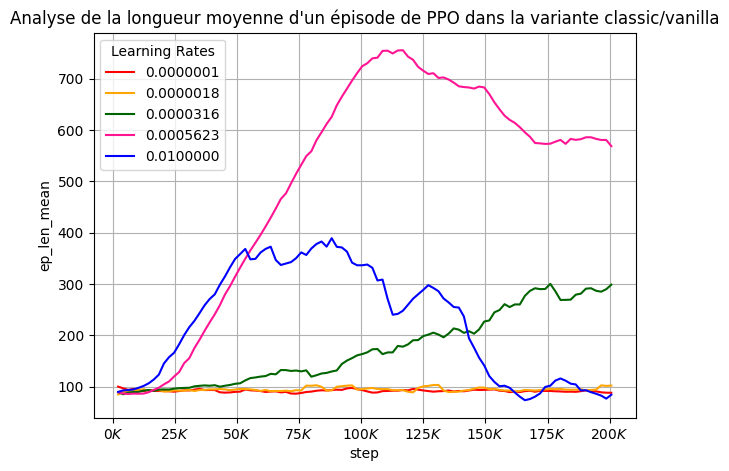

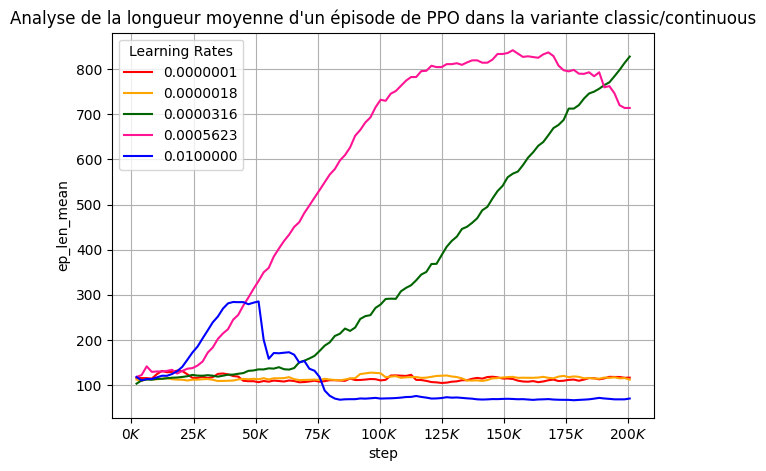

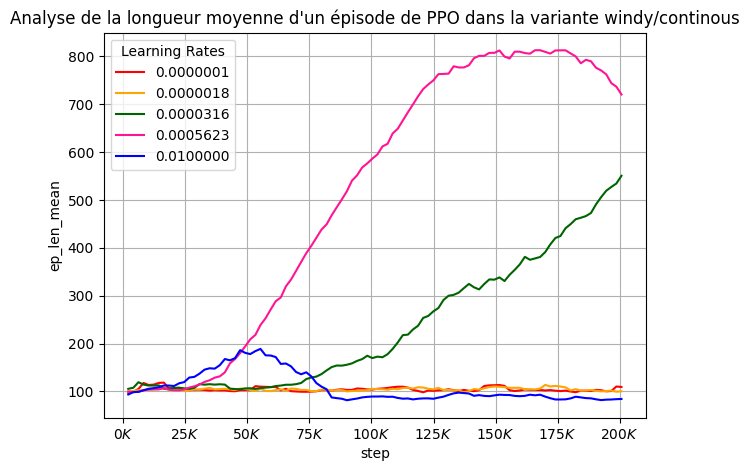

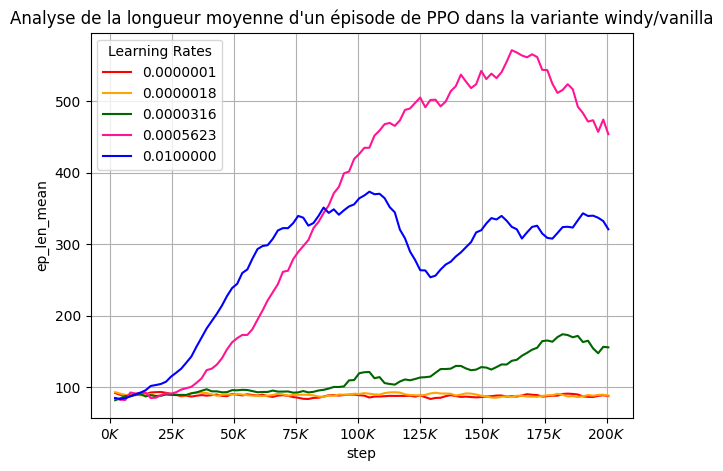

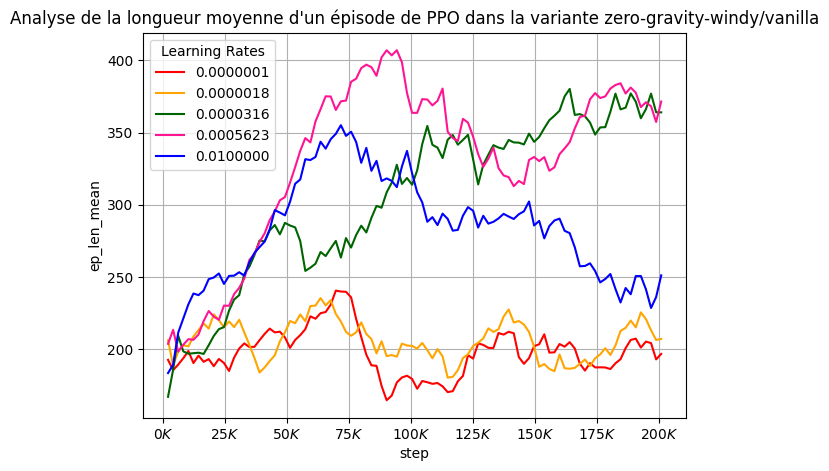

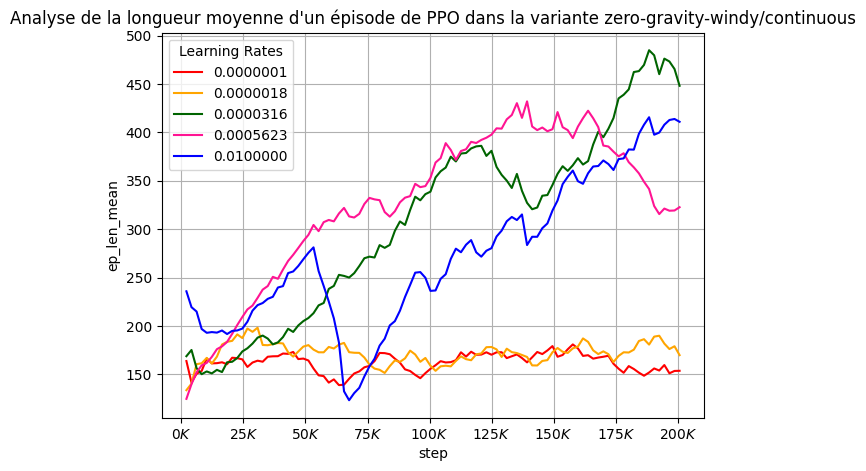

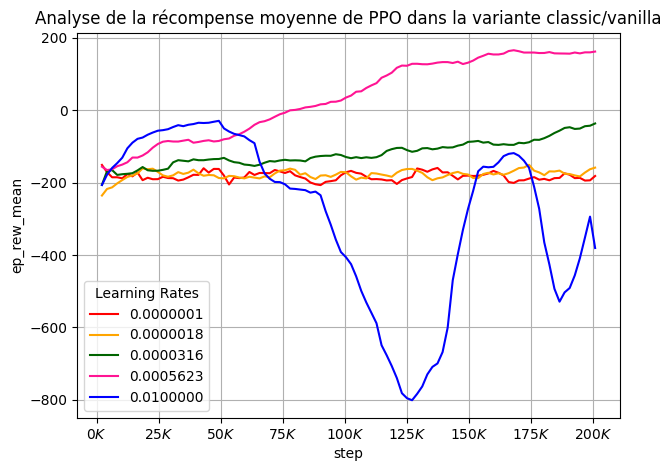

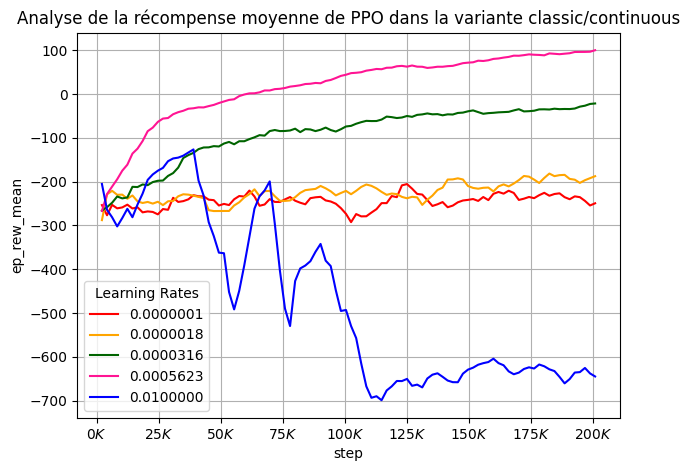

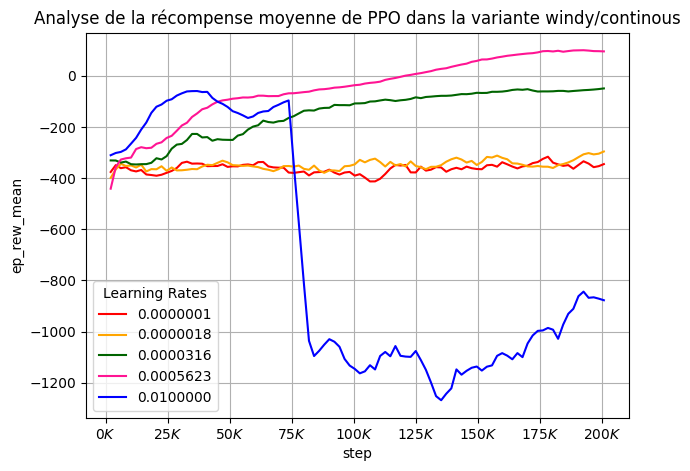

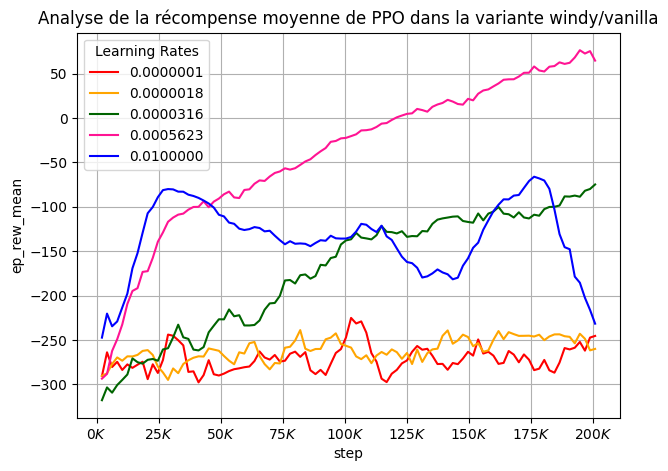

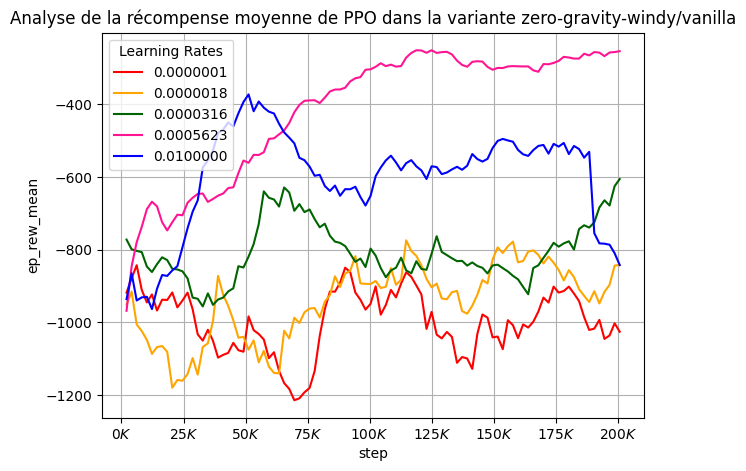

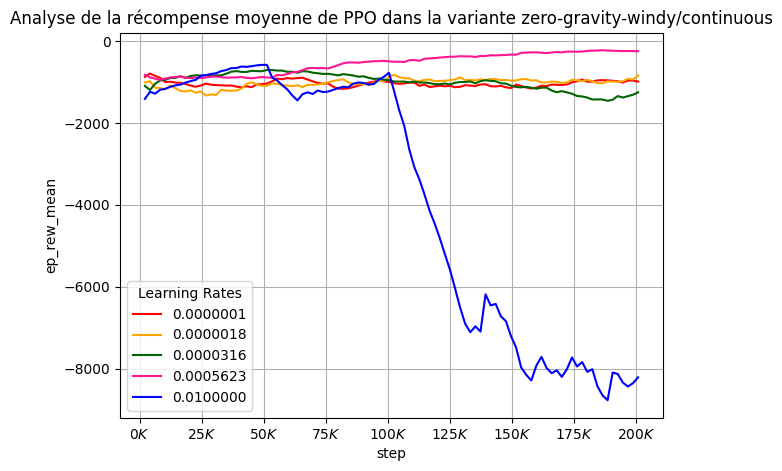

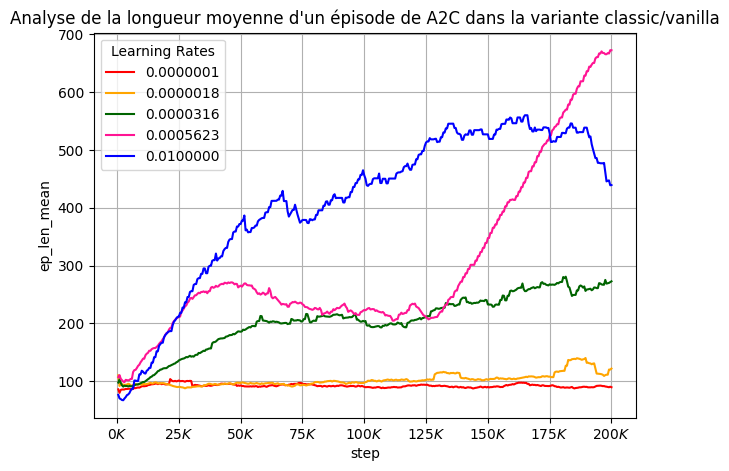

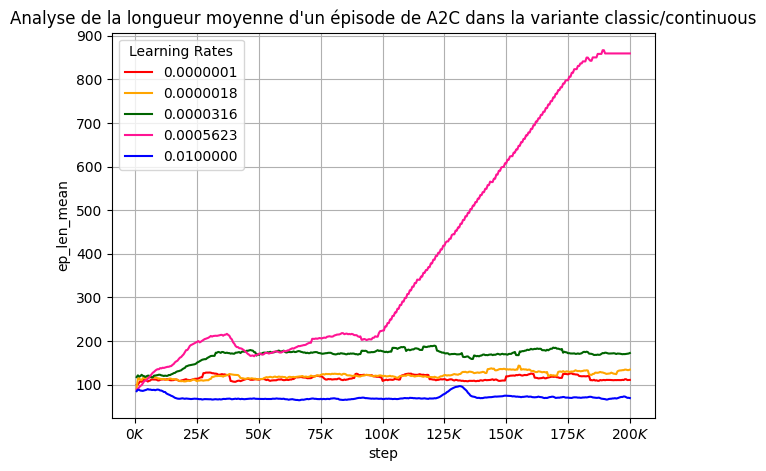

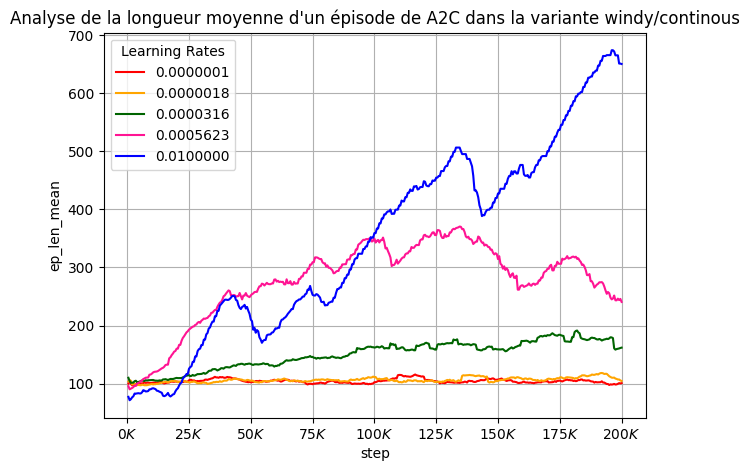

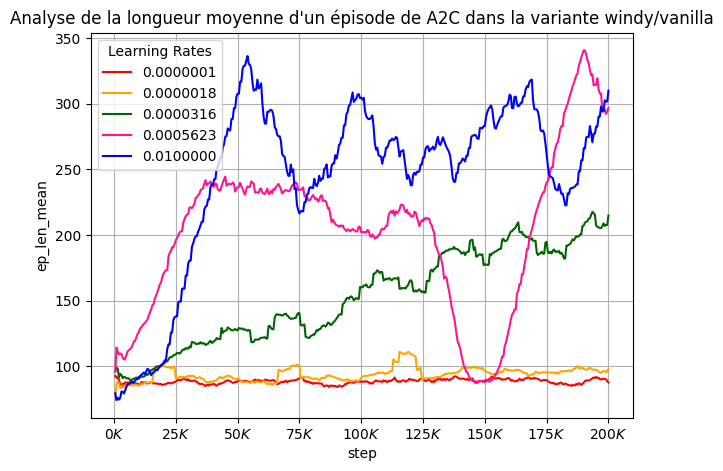

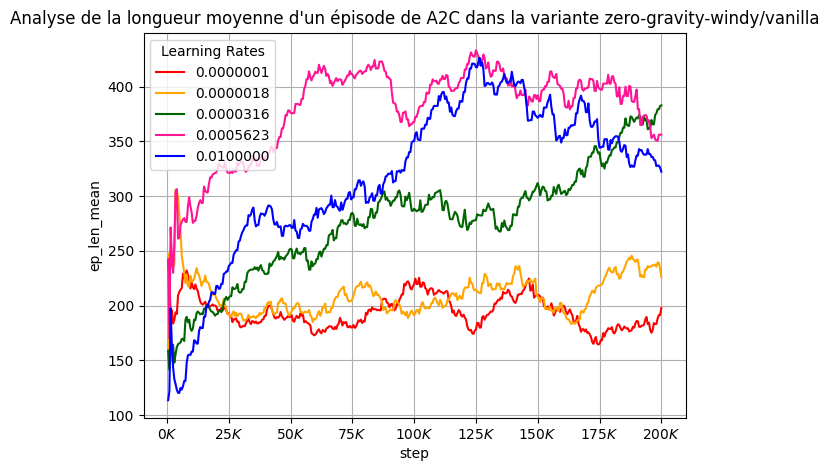

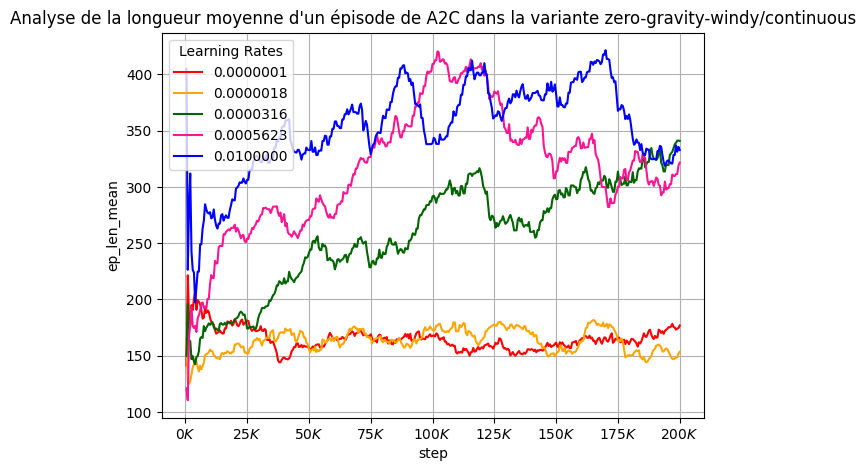

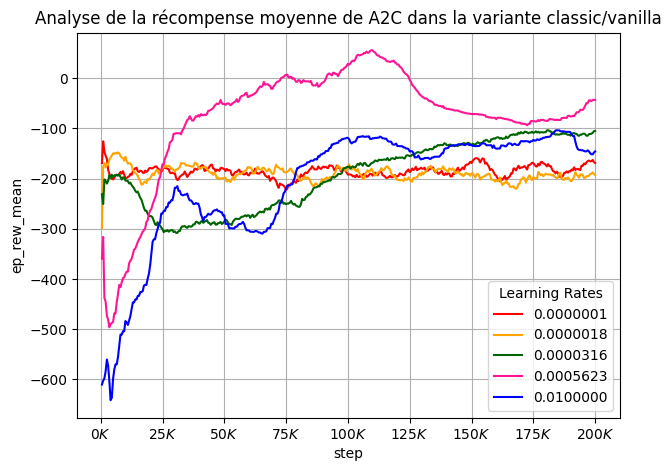

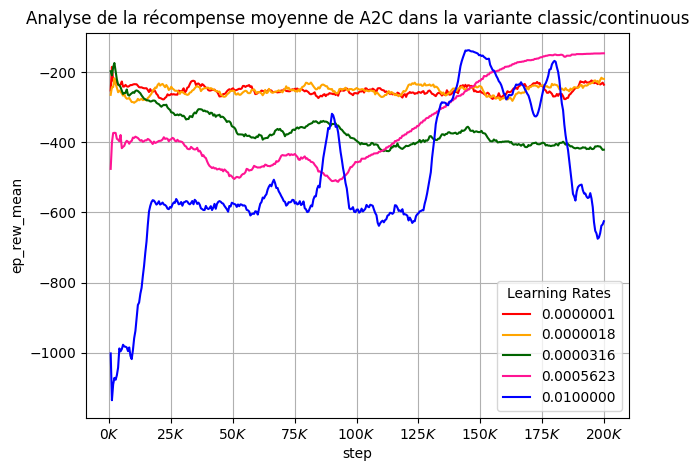

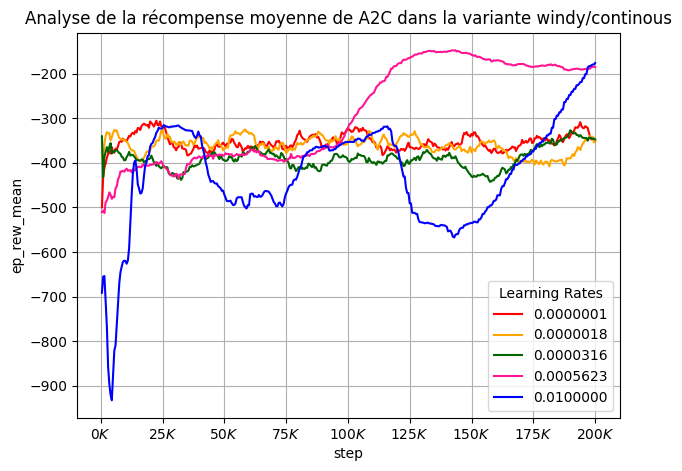

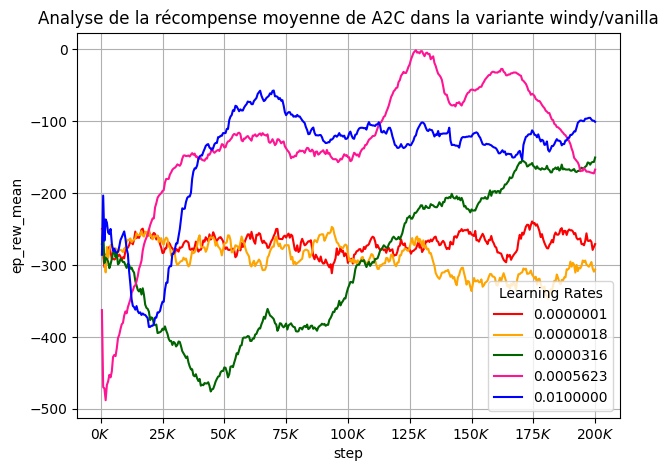

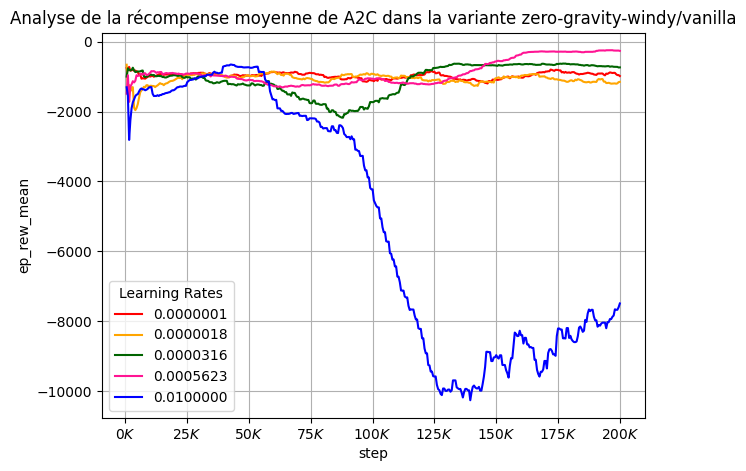

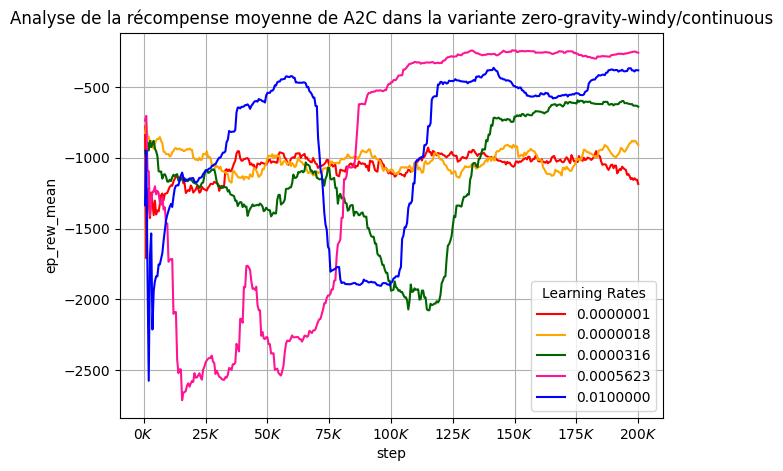

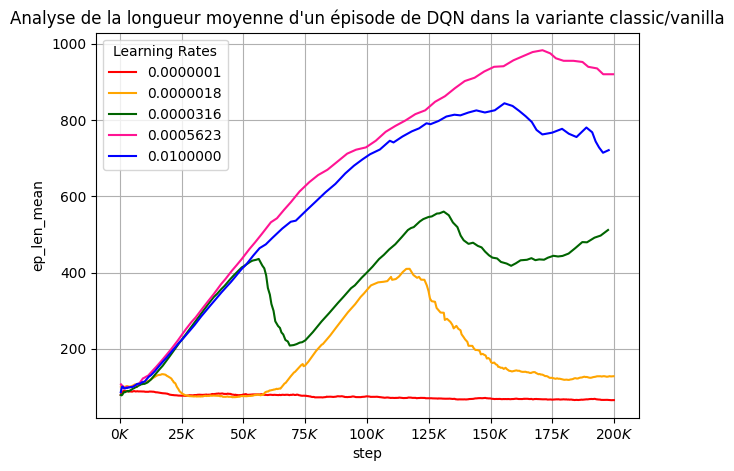

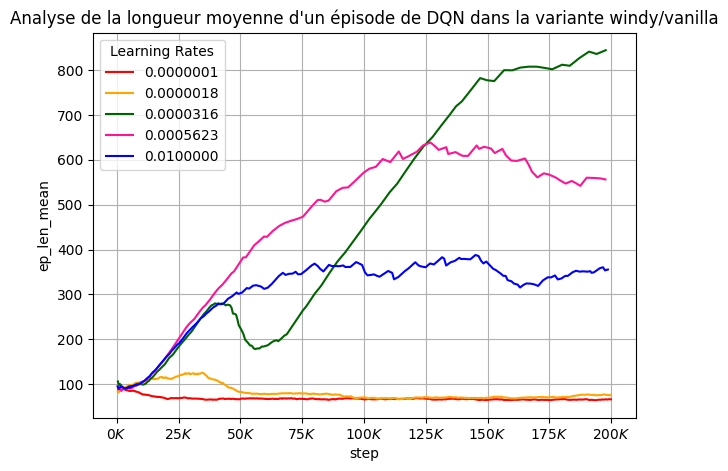

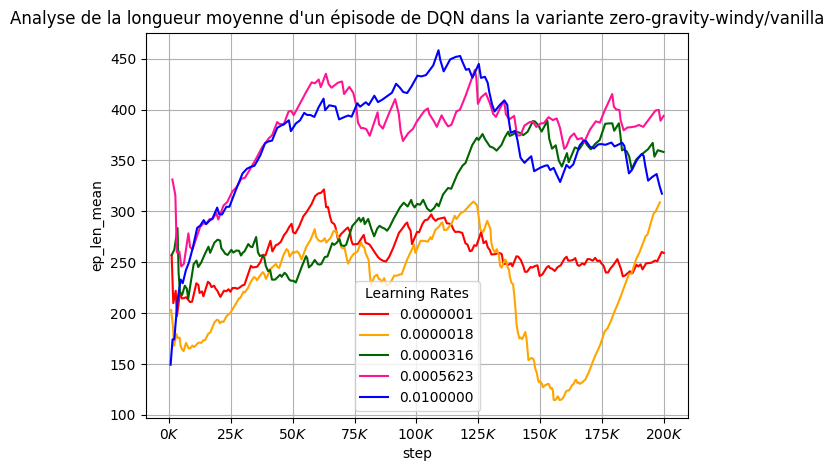

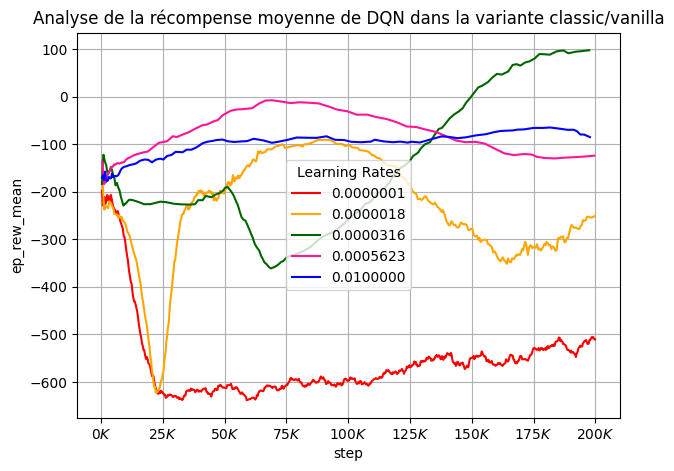

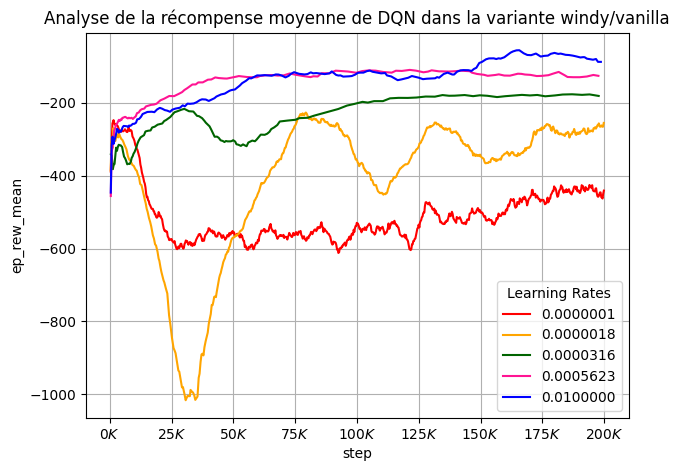

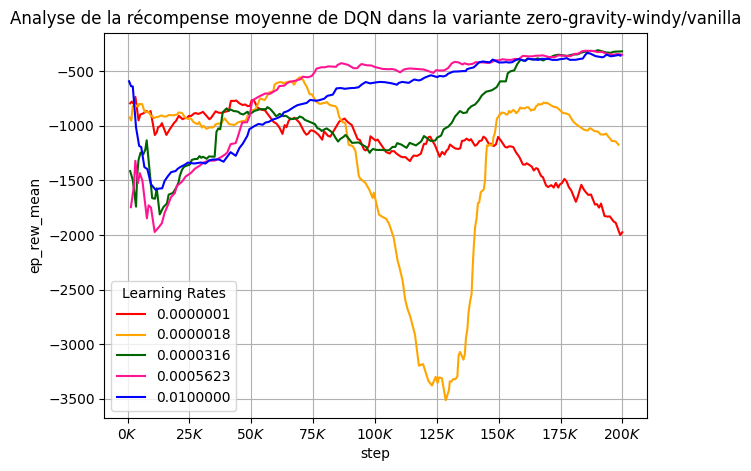

In [6]:
def format_k(x, pos):
    """Fonction pour formatter l'axe des abscisses (eg 100 000 => 100K)"""
    return f'${int(x/1000)}K$'

# Méthodes à évaluer
methods = ["PPO", "A2C", "DQN"]

# Chemin vers le dossier des graphiques
figures_dir = Path() / "figures"
figures_dir.mkdir(parents=True, exist_ok=True)

# Mapping de color par learning rate
color_mapping = dict(zip(map(lambda lr: f"{lr:.7f}", learning_rates), [COLORS["red"], COLORS["orange"], COLORS["darkgreen"], COLORS["deeppink"], COLORS["blue"]]))

# Pour chaque algorithme...
for method in methods:
    
    # Pour chaque level de profondeur 1 dans data_dir (ici que rollout)...
    for level1 in data_dir.iterdir():
        
        # Pour chaque level de profondeur 2 dans data_dir (e.g. ep_len_mean )...
        for level2 in level1.iterdir():
            
            # Pour chaque problème (e.g. classic, windy, zero-gravity-windy)...
            for task_dir in level2.iterdir():

                # Pour chaque variante (e.g continuous, vanilla)...
                for variant_dir in task_dir.iterdir():

                    print(variant_dir, method)
                    
                    # Vérification qu'un fichier est exploitable à cet endroit avec la méthode souhaitée 
                    # Permet d'évacuer le cas où le modèle est DQN et qu'on est avec variant_dir=continuous
                    if list(variant_dir.glob(f"{method}*")) == []:
                        continue
                    
                    # Création de la figure
                    fig, ax = plt.subplots(figsize=(7,5))

                    # Chemin de sortie (1 graphique par méthode)
                    output_path = figures_dir / task_dir.name / variant_dir.name / method

                    # Pour chaque taux d'apprentissage...
                    for learning_rate in learning_rates:

                        # Affichage du learning rate sur 9 caractères
                        learning_rate = f"{learning_rate:.7f}"

                        # Récupération du premier fichier du dossier avec la méthode et taux d'apprentissage
                        file = list(variant_dir.glob(f"{method}*{learning_rate}*"))[0]
                        
                        # Récupération de la couleur associé à ce learning rate
                        color = color_mapping[learning_rate]

                        # Récupération du fichier de métadonnées (e.g. data/rollout/ep_rew_mean/windy/continous/A2C_0.0000001_200K_windy-continuous_1.csv)
                        df = pd.read_csv(file)

                        # Affichage du quadrillage
                        ax.grid()

                        # Dessin de la courbe associée au level2 courant
                        ax.plot(df["step"], df["value"], color=color, label=f"{learning_rate}")

                    # Ajout d'une légende
                    ax.legend(title="Learning Rates")

                    # Nommage des axes et formattage
                    ax.set_xlabel("step")
                    ax.set_ylabel(level2.name)
                    ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_k))
   
                    # enregistrement
                    (output_path).mkdir(parents=True, exist_ok=True)
                    fig.savefig(output_path / f"{method}_{task_dir.name}-{variant_dir.name}_{level1.name}-{level2.name}.png")

                    # Ajout d'un titre
                    if level2.name == "ep_rew_mean":
                        ax.set_title(f"Analyse de la récompense moyenne de {method} dans la variante {task_dir.name}/{variant_dir.name}")
                    else:
                        ax.set_title(f"Analyse de la longueur moyenne d'un épisode de {method} dans la variante {task_dir.name}/{variant_dir.name}")



                        

#### Enregistrement de vidéos de PPO pour analyser la qualité de l'entrainement

In [7]:
model_path_PPO_classic_vanilla = Path() / "models" / "lunar_lander" / "classic" / "vanilla" / "lunar_lander_PPO_0.0005623_200K_classic-vanilla"
model_path_PPO_classic_continuous = Path() / "models" / "lunar_lander" / "classic" / "continuous" / "lunar_lander_PPO_0.0005623_200K_classic-continuous"
model_path_PPO_windy_vanilla = Path() / "models" / "lunar_lander" / "windy" / "vanilla" / "lunar_lander_PPO_0.0005623_200K_windy-vanilla"
model_path_PPO_windy_continuous = Path() / "models" / "lunar_lander" / "windy" / "continuous" / "lunar_lander_PPO_0.0005623_200K_windy-continuous"
model_path_PPO_zero_gravity_windy_vanilla = Path() / "models" / "lunar_lander" / "zero-gravity-windy" / "vanilla" / "lunar_lander_PPO_0.0005623_200K_zero-gravity-windy-vanilla"
model_path_PPO_zero_gravity_windy_continuous = Path() / "models" / "lunar_lander" / "zero-gravity-windy" / "continuous" / "lunar_lander_PPO_0.0005623_200K_zero-gravity-windy-continuous"

model_paths = [
    model_path_PPO_classic_vanilla,
    model_path_PPO_classic_continuous,
    model_path_PPO_windy_vanilla,
    model_path_PPO_windy_continuous,
    model_path_PPO_zero_gravity_windy_vanilla,
    model_path_PPO_zero_gravity_windy_continuous
]

for model_path in model_paths:
    LearningScheduler.record_videos_from_trained_models(model_path, runs=5)

/Users/oscar/Documents/Université/M2_IASD/Apprentissage_par_Renforcement/gym_notebooks/Reinforcement-Learning-Applications/lunar-lander/.venv/lib/python3.13/site-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /Users/oscar/Documents/Université/M2_IASD/Apprentissage_par_Renforcement/gym_notebooks/Reinforcement-Learning-Applications/lunar-lander/videos/classic/vanilla/lunar_lander_PPO_0.0005623_200K_classic-vanilla folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


(0) total_reward=np.float64(194.26765620477497)
(1) total_reward=np.float64(219.68452373809248)
(2) total_reward=np.float64(146.9752736608013)
(3) total_reward=np.float64(205.38683605597987)
(4) total_reward=np.float64(230.31240995568785)


/Users/oscar/Documents/Université/M2_IASD/Apprentissage_par_Renforcement/gym_notebooks/Reinforcement-Learning-Applications/lunar-lander/.venv/lib/python3.13/site-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /Users/oscar/Documents/Université/M2_IASD/Apprentissage_par_Renforcement/gym_notebooks/Reinforcement-Learning-Applications/lunar-lander/videos/classic/continuous/lunar_lander_PPO_0.0005623_200K_classic-continuous folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


(0) total_reward=np.float64(124.2886429243463)
(1) total_reward=np.float64(146.89334494363078)
(2) total_reward=np.float64(-86.16558221395242)
(3) total_reward=np.float64(129.72308357024986)
(4) total_reward=np.float64(30.672893405483194)


/Users/oscar/Documents/Université/M2_IASD/Apprentissage_par_Renforcement/gym_notebooks/Reinforcement-Learning-Applications/lunar-lander/.venv/lib/python3.13/site-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /Users/oscar/Documents/Université/M2_IASD/Apprentissage_par_Renforcement/gym_notebooks/Reinforcement-Learning-Applications/lunar-lander/videos/windy/vanilla/lunar_lander_PPO_0.0005623_200K_windy-vanilla folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


(0) total_reward=np.float64(-80.3264096242432)
(1) total_reward=np.float64(74.56369060562697)
(2) total_reward=np.float64(-50.916427508743794)
(3) total_reward=np.float64(197.418609496425)
(4) total_reward=np.float64(-59.40209056797373)


/Users/oscar/Documents/Université/M2_IASD/Apprentissage_par_Renforcement/gym_notebooks/Reinforcement-Learning-Applications/lunar-lander/.venv/lib/python3.13/site-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /Users/oscar/Documents/Université/M2_IASD/Apprentissage_par_Renforcement/gym_notebooks/Reinforcement-Learning-Applications/lunar-lander/videos/windy/continuous/lunar_lander_PPO_0.0005623_200K_windy-continuous folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


(0) total_reward=np.float64(183.96671901918302)
(1) total_reward=np.float64(80.77682685367554)
(2) total_reward=np.float64(147.18751320142263)
(3) total_reward=np.float64(166.50567081803644)
(4) total_reward=np.float64(133.54741031720135)


/Users/oscar/Documents/Université/M2_IASD/Apprentissage_par_Renforcement/gym_notebooks/Reinforcement-Learning-Applications/lunar-lander/.venv/lib/python3.13/site-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /Users/oscar/Documents/Université/M2_IASD/Apprentissage_par_Renforcement/gym_notebooks/Reinforcement-Learning-Applications/lunar-lander/videos/zero-gravity-windy/vanilla/lunar_lander_PPO_0.0005623_200K_zero-gravity-windy-vanilla folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


(0) total_reward=np.float64(-159.45543088161844)
(1) total_reward=np.float64(-477.3906873297901)
(2) total_reward=np.float64(-92.58629414329593)
(3) total_reward=np.float64(-234.8886509993671)
(4) total_reward=np.float64(-833.9850362249991)


/Users/oscar/Documents/Université/M2_IASD/Apprentissage_par_Renforcement/gym_notebooks/Reinforcement-Learning-Applications/lunar-lander/.venv/lib/python3.13/site-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /Users/oscar/Documents/Université/M2_IASD/Apprentissage_par_Renforcement/gym_notebooks/Reinforcement-Learning-Applications/lunar-lander/videos/zero-gravity-windy/continuous/lunar_lander_PPO_0.0005623_200K_zero-gravity-windy-continuous folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


(0) total_reward=np.float64(-192.10029616393408)
(1) total_reward=np.float64(-110.40594972066256)
(2) total_reward=np.float64(-309.65369691864555)
(3) total_reward=np.float64(-365.7434084929303)
(4) total_reward=np.float64(-235.1193423388984)
